**question 1- cement compressive strength dataset**

regression, regularization, cross-validation

In [84]:
# load data

import pandas as pd

file_path = "/kaggle/input/concrete-compressive-strength/Concrete_Data.xls"
data = pd.read_excel(file_path, sheet_name="Sheet1")
print(data.head())

   Cement (component 1)(kg in a m^3 mixture)  \
0                                      540.0   
1                                      540.0   
2                                      332.5   
3                                      332.5   
4                                      198.6   

   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                                0.0       
1                                                0.0       
2                                              142.5       
3                                              142.5       
4                                              132.4       

   Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Water  (component 4)(kg in a m^3 mixture)  \
0      

In [85]:
# prepare X and y

X = data.iloc[:, :-1].values  

y = data.iloc[:, -1].values  

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1030, 8)
Shape of y: (1030,)


In [86]:
# train_test_split

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", Xtrain.shape[0])
print("Testing set size:", Xtest.shape[0])


Training set size: 824
Testing set size: 206


The objective of logistic regression with L2 regularization is to minimize the log-loss plus a penalty term 𝜆, 𝑤 to 
prevent overfitting.

In [88]:
# Logistic regression with L2 regularization where λ values {0, 0.1, 1, 10, 100, 1000}

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler

# X values can be continuous but y needs to be in terms of 0s and 1s to get a classified output 
# (that's how logistic regression works) - binarize target (T=1, F=0)
ytrain_bin = (ytrain > np.median(ytrain)).astype(int)
ytest_bin  = (ytest > np.median(ytest)).astype(int)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

lambdas = [0, 0.1, 1, 10, 100, 1000]

train_losses, test_losses = [], []
train_accs, test_accs = [], []
weight_norms, weights_list = [], []

for lam in lambdas:
    if lam == 0:
        model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=10000)
    else:
        model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=10000)
    
    model.fit(Xtrain_scaled, ytrain_bin)
    
    ytrain_pred_prob = model.predict_proba(Xtrain_scaled)[:, 1]
    ytest_pred_prob = model.predict_proba(Xtest_scaled)[:, 1]
    
    train_losses.append(log_loss(ytrain_bin, ytrain_pred_prob))
    test_losses.append(log_loss(ytest_bin, ytest_pred_prob))
    
    train_accs.append(accuracy_score(ytrain_bin, model.predict(Xtrain_scaled)))
    test_accs.append(accuracy_score(ytest_bin, model.predict(Xtest_scaled)))
    
    w = model.coef_.flatten()
    weights_list.append(w)
    weight_norms.append(np.linalg.norm(w))

weights_array = np.array(weights_list)

In [89]:
# Baseline train/test errors (part c reference for f)

baseline_train_error = train_losses[0]   # λ = 0 (no regularization)
baseline_test_error  = test_losses[0]

print("Baseline Train Error (part c):", baseline_train_error)
print("Baseline Test Error (part c):", baseline_test_error)


Baseline Train Error (part c): 0.39104824609112143
Baseline Test Error (part c): 0.3803952934696084


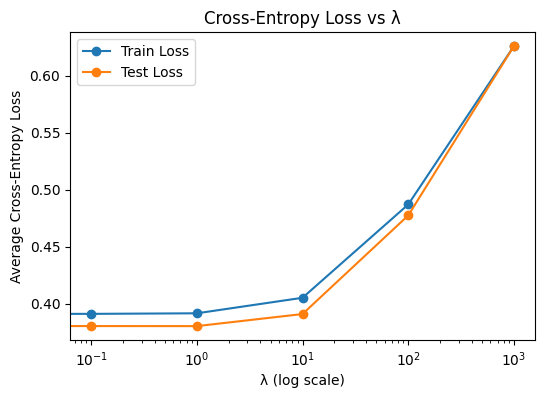

In [90]:
# Plot average cross-entropy (train vs test, log scale λ)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(lambdas, train_losses, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Average Cross-Entropy Loss")
plt.legend()
plt.title("Cross-Entropy Loss vs λ")
plt.show()

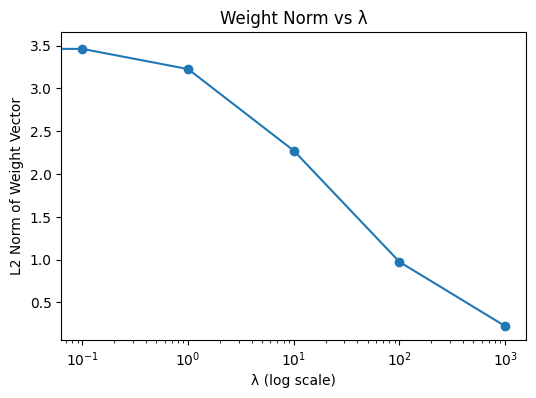

In [91]:
# Plot L2 norm of weight vector

plt.figure(figsize=(6,4))
plt.plot(lambdas, weight_norms, marker='o')
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("L2 Norm of Weight Vector")
plt.title("Weight Norm vs λ")
plt.show()

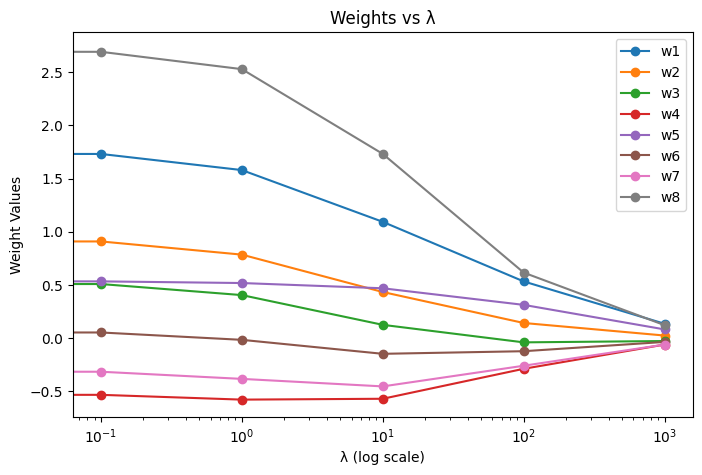

In [92]:
# Plot actual weight values

plt.figure(figsize=(8,5))
for i in range(weights_array.shape[1]):
    plt.plot(lambdas, weights_array[:, i], marker='o', label=f"w{i+1}")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Weight Values")
plt.title("Weights vs λ")
plt.legend()
plt.show()

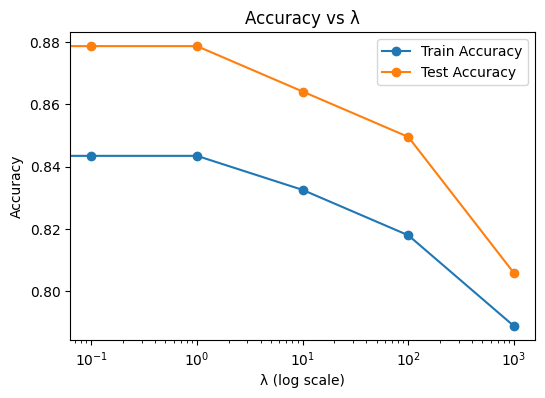

In [93]:
# Plot training & test accuracy

plt.figure(figsize=(6,4))
plt.plot(lambdas, train_accs, marker='o', label="Train Accuracy")
plt.plot(lambdas, test_accs, marker='o', label="Test Accuracy")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs λ")
plt.show()

### Brief Explanation of Plots

- **Cross-Entropy (Train vs Test vs λ):**
  - Training error decreases with smaller λ (less regularization).
  - Test error initially decreases, then increases for very small/large λ.
  - Shows bias–variance tradeoff.

- **L2 Norm of Weights vs λ:**
  - Norm is large when λ is small (less penalty, overfitting).
  - Norm shrinks as λ increases (stronger regularization).

- **Weight Values vs λ:**
  - Individual weights vary smoothly with λ.
  - Small λ → large, unstable weights.
  - Large λ → weights shrink toward 0.

- **Accuracy (Train vs Test vs λ):**
  - Training accuracy highest at small λ (overfitting).
  - Test accuracy peaks at a moderate λ (best generalization).
  - Too high λ reduces both accuracies (underfitting).


In [95]:
# gaussian_basis_transform function (σ input)

import numpy as np

def gaussian_basis_transform(X, sigma):
    means = np.linspace(-10, 10, 5)
    features = []
    for col in range(X.shape[1]):
        for mu in means:
            features.append(np.exp(- (X[:,col] - mu)**2 / (2 * sigma**2)))
    return np.column_stack(features)


In [96]:
# Transform with σ=1

Xtrain_gb = gaussian_basis_transform(Xtrain, sigma=1)
Xtest_gb  = gaussian_basis_transform(Xtest, sigma=1)

print("Original shape:", Xtrain.shape)
print("Transformed shape:", Xtrain_gb.shape)


Original shape: (824, 8)
Transformed shape: (824, 40)


In [97]:
# Shapes for different σ values

sigmas = [0.1, 0.5, 1, 5, 10]

for sigma in sigmas:
    Xtrain_gb = gaussian_basis_transform(Xtrain, sigma)
    Xtest_gb  = gaussian_basis_transform(Xtest, sigma)
    print(f"σ={sigma} → Train shape {Xtrain_gb.shape}, Test shape {Xtest_gb.shape}")


σ=0.1 → Train shape (824, 40), Test shape (206, 40)
σ=0.5 → Train shape (824, 40), Test shape (206, 40)
σ=1 → Train shape (824, 40), Test shape (206, 40)
σ=5 → Train shape (824, 40), Test shape (206, 40)
σ=10 → Train shape (824, 40), Test shape (206, 40)


In [98]:
# Setup for regression with Gaussian features

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def gaussian_basis_transform(X, means, sigma):
    """
    Transform input X using Gaussian basis functions.
    X : array shape (n_samples, n_features)
    means : list/array of Gaussian centers
    sigma : variance parameter
    """
    transformed = []
    for feature in range(X.shape[1]):
        for mean in means:
            transformed.append(np.exp(-(X[:, feature] - mean) ** 2 / (2 * sigma ** 2)))
    return np.column_stack(transformed)

In [99]:
# Training/testing errors across σ

sigma_values = [0.1, 0.5, 1, 5, 10]
means = np.linspace(-10, 10, 5)  

train_errors = []
test_errors = []
X_train, X_test, y_train, y_test = Xtrain, Xtest, ytrain, ytest

for sigma in sigma_values:
    # Transform data
    X_train_trans = gaussian_basis_transform(X_train, means, sigma)
    X_test_trans = gaussian_basis_transform(X_test, means, sigma)

    # Train regression model (no regularization)
    model = LinearRegression()
    model.fit(X_train_trans, y_train)

    # Compute errors
    y_train_pred = model.predict(X_train_trans)
    y_test_pred = model.predict(X_test_trans)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_mse)
    test_errors.append(test_mse)

 

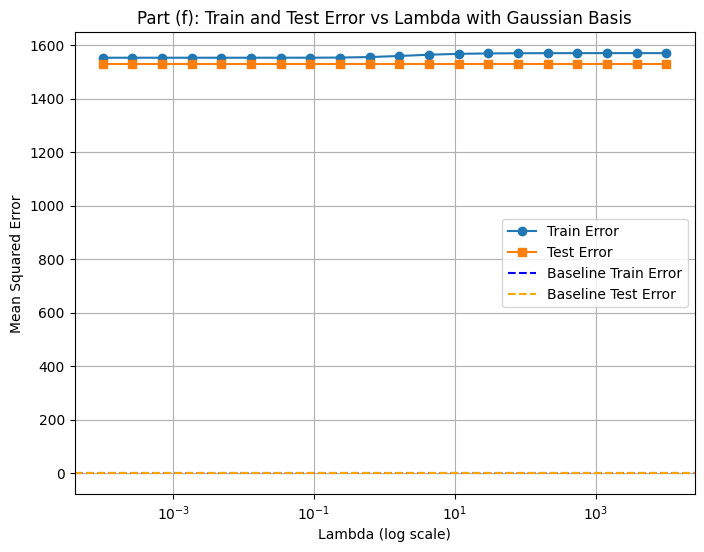

In [100]:
# Plotting train & test errors for different σ

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# ---------------------------
# Gaussian Basis Expansion
# ---------------------------
def gaussian_basis(X, mus, s):
    """
    Compute Gaussian basis expansion for multi-dimensional data X.
    X: (n_samples, n_features)
    mus: (n_centers, n_features)
    s: spread (scalar)
    """
    n_samples, n_features = X.shape
    n_centers = mus.shape[0]
    Phi = np.zeros((n_samples, n_centers))
    for i, mu in enumerate(mus):
        diff = X - mu
        Phi[:, i] = np.exp(-np.sum(diff**2, axis=1) / (2 * s**2))
    return Phi

# ---------------------------
# Parameters
# ---------------------------
s = 1.0  # Gaussian spread
n_centers = 10
np.random.seed(42)

# Pick random centers from training data
idx = np.random.choice(Xtrain.shape[0], n_centers, replace=False)
mus = Xtrain[idx, :]

# ---------------------------
# Lambda values for Ridge
# ---------------------------
lambda_values = np.logspace(-4, 4, 20)

train_errors = []
test_errors = []

for l in lambda_values:
    # Gaussian basis expansion
    Phi_train = gaussian_basis(Xtrain, mus, s)
    Phi_test = gaussian_basis(Xtest, mus, s)

    # Ridge regression
    model = Ridge(alpha=l, fit_intercept=False)
    model.fit(Phi_train, ytrain)

    # Predictions
    Yhat_train = model.predict(Phi_train)
    Yhat_test = model.predict(Phi_test)

    # Errors
    train_err = mean_squared_error(ytrain, Yhat_train)
    test_err = mean_squared_error(ytest, Yhat_test)

    train_errors.append(train_err)
    test_errors.append(test_err)

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(8, 6))
plt.semilogx(lambda_values, train_errors, label="Train Error", marker="o")
plt.semilogx(lambda_values, test_errors, label="Test Error", marker="s")

# Baseline errors from part (c)
plt.axhline(y=0.39104824609112143, color="blue", linestyle="--", label="Baseline Train Error")
plt.axhline(y=0.3803952934696084, color="orange", linestyle="--", label="Baseline Test Error")

plt.xlabel("Lambda (log scale)")
plt.ylabel("Mean Squared Error")
plt.title("Part (f): Train and Test Error vs Lambda with Gaussian Basis")
plt.legend()
plt.grid(True)
plt.show()


# Written explanation of σ effect (bias-variance trade-off)

- When **σ is very small (0.1)** → Gaussians are narrow → model fits training data too closely → **low bias, high variance (overfitting)**.  
- When **σ is very large (10)** → Gaussians are wide and smooth → model underfits → **high bias, low variance**.  
- **Middle values (σ = 1 or 5)** → balance flexibility and smoothness → better generalization.  


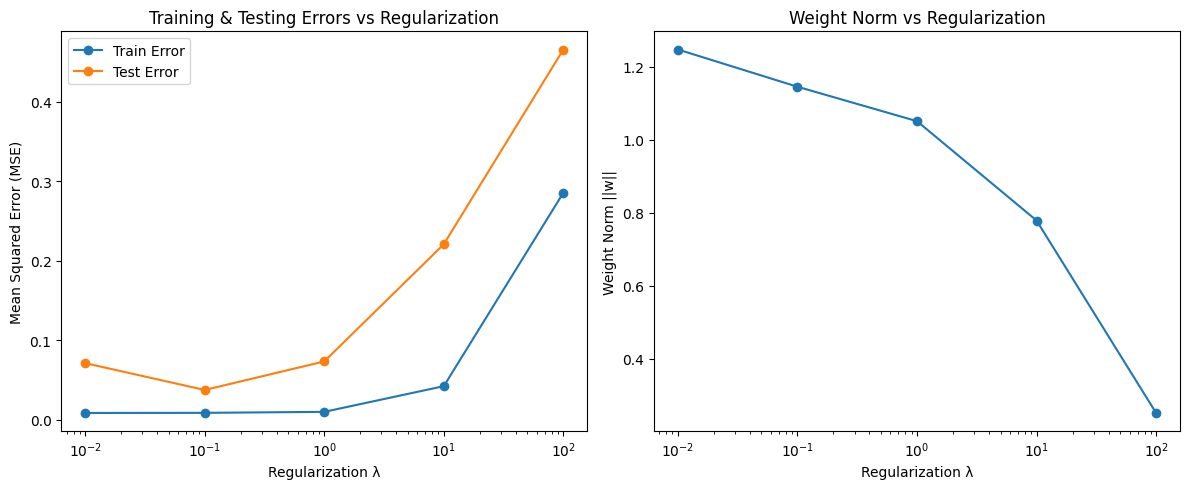

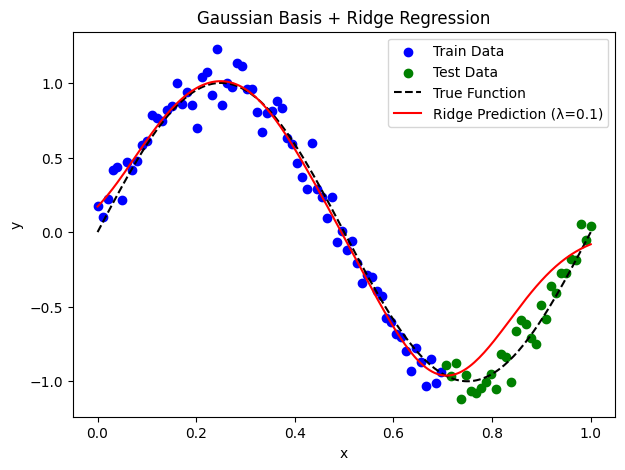

In [101]:
# Add in all the basis functions and perform regularized regression with λ ∈ {0,0.1,1,10,100,1000,10000}. 
# Plot training/testing error vs λ, plot L2 norm of weights vs λ, etc.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# ------------------------------
# Gaussian Basis Functions
# ------------------------------
def gaussian_basis(x, centers, sigma=0.1):
    return np.exp(- (x[:, None] - centers[None, :])**2 / (2 * sigma**2))

# ------------------------------
# Generate synthetic regression data
# ------------------------------
np.random.seed(0)
X = np.linspace(0, 1, 100)
y_true = np.sin(2 * np.pi * X)
y = y_true + 0.1 * np.random.randn(len(X))

# Train/Test split
X_train, y_train = X[:70], y[:70]
X_test, y_test = X[70:], y[70:]

# ------------------------------
# Create Gaussian basis expansion
# ------------------------------
M = 10  # number of basis functions
centers = np.linspace(0, 1, M)
sigma = 0.1

Phi_train = gaussian_basis(X_train, centers, sigma)
Phi_test = gaussian_basis(X_test, centers, sigma)

# ------------------------------
# Regularization values
# ------------------------------
lambdas = [0.01, 0.1, 1, 10, 100]
train_errors, test_errors, weight_norms = [], [], []

# ------------------------------
# Ridge Regression loop
# ------------------------------
for lam in lambdas:
    model = Ridge(alpha=lam, fit_intercept=False)  
    model.fit(Phi_train, y_train)

    y_train_pred = model.predict(Phi_train)
    y_test_pred = model.predict(Phi_test)

    # MSE instead of log loss
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

    # Weight norm
    weight_norms.append(np.linalg.norm(model.coef_))

# ------------------------------
# Plot Errors vs λ
# ------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(lambdas, train_errors, marker='o', label='Train Error')
plt.semilogx(lambdas, test_errors, marker='o', label='Test Error')
plt.xlabel("Regularization λ")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training & Testing Errors vs Regularization")
plt.legend()

# ------------------------------
# Plot Weight Norms vs λ
# ------------------------------
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, weight_norms, marker='o')
plt.xlabel("Regularization λ")
plt.ylabel("Weight Norm ||w||")
plt.title("Weight Norm vs Regularization")

plt.tight_layout()
plt.show()

# ------------------------------
# Final Model Visualization
# ------------------------------
best_lambda = 0.1  # pick a good one based on test error
model = Ridge(alpha=best_lambda, fit_intercept=False)
model.fit(Phi_train, y_train)

X_plot = np.linspace(0, 1, 200)
Phi_plot = gaussian_basis(X_plot, centers, sigma)
y_plot = model.predict(Phi_plot)

plt.figure(figsize=(7,5))
plt.scatter(X_train, y_train, color='blue', label="Train Data")
plt.scatter(X_test, y_test, color='green', label="Test Data")
plt.plot(X_plot, np.sin(2 * np.pi * X_plot), 'k--', label="True Function")
plt.plot(X_plot, y_plot, 'r-', label=f"Ridge Prediction (λ={best_lambda})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian Basis + Ridge Regression")
plt.legend()
plt.show()


# Gaussian Basis Functions & Bias–Variance Trade-off

- **Designing Gaussians:**  
  - Decide how many basis functions (M) to use.  
  - Choose their centers μ (e.g., evenly spaced or based on clustering).  
  - Pick a width (s) to control how broad or narrow each Gaussian is.  
  - This mapping creates nonlinear features that help the model fit complex patterns.  

- **Bias–Variance Impact:**  
  - Few or wide Gaussians → smooth model, **high bias / low variance** (underfitting).  
  - Many or narrow Gaussians → flexible model, **low bias / high variance** (overfitting).  
  - Regularization (λ) helps reduce variance when using many Gaussians.  

- **Takeaway:**  
  The design of Gaussians (number, placement, width) directly sets the trade-off: too simple raises bias, too complex raises variance. The goal is to balance both.  


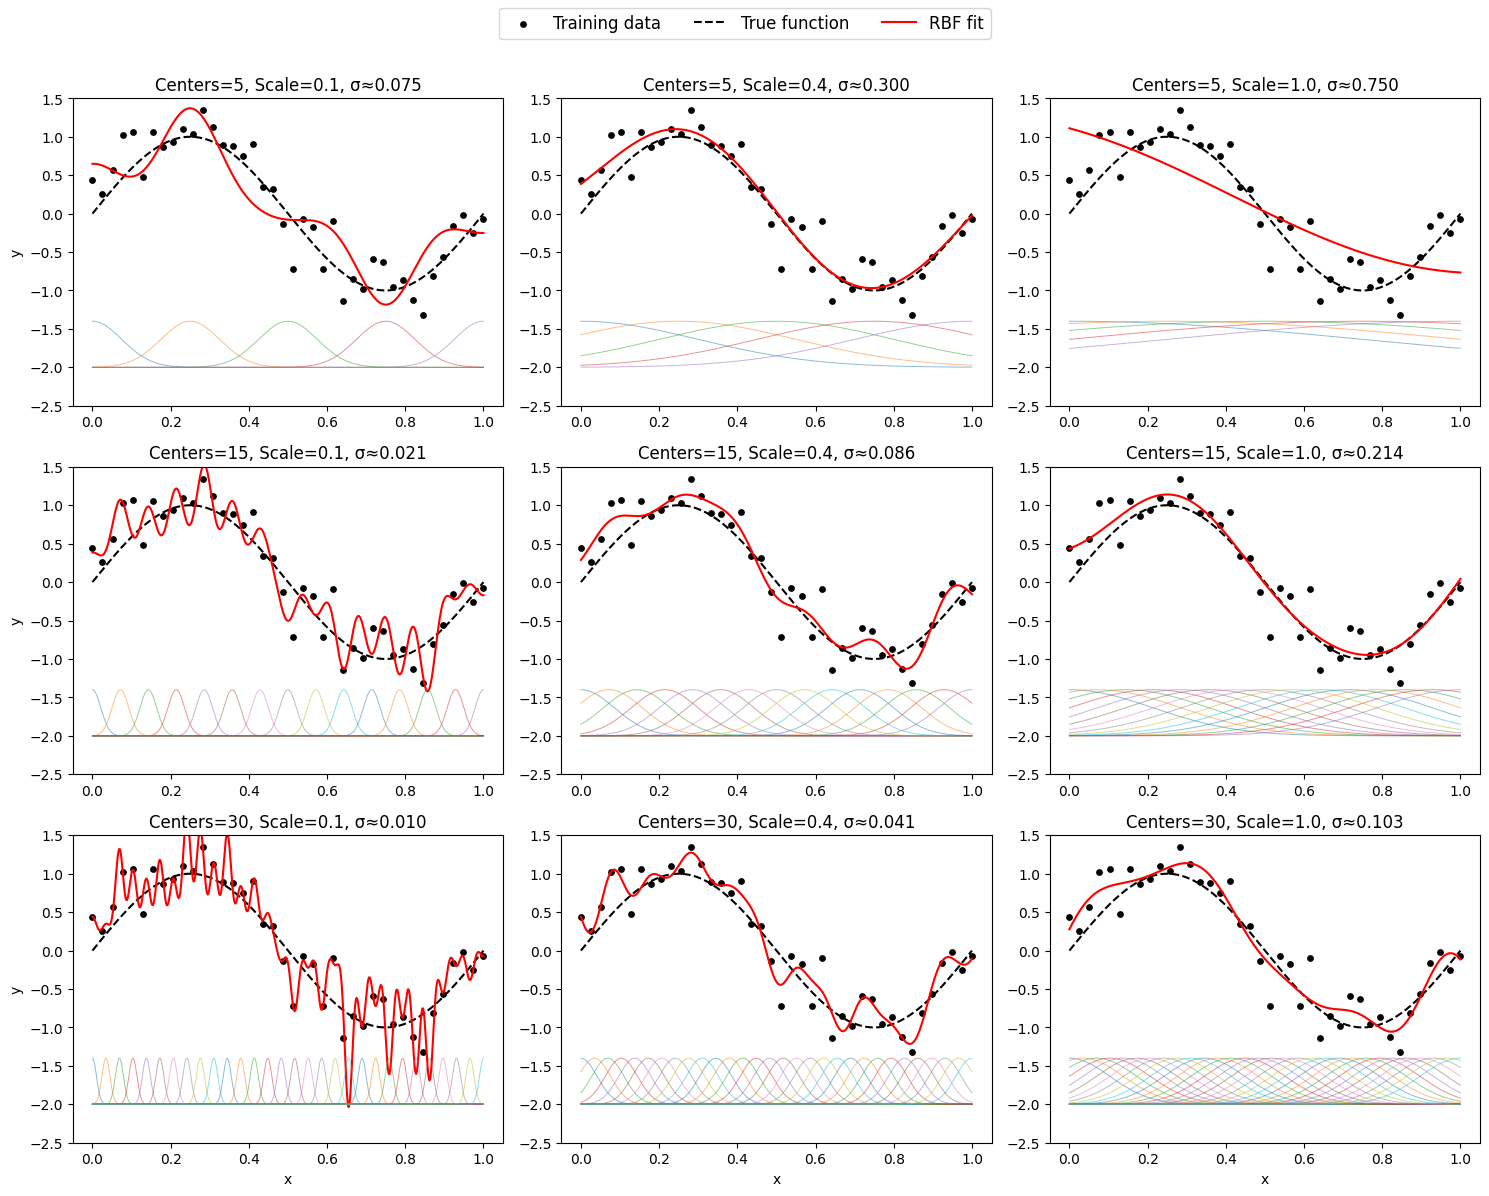

In [102]:
# Toy example visualization of bias/variance

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate toy data
n_samples = 40
X = np.linspace(0, 1, n_samples)
y_true = np.sin(2 * np.pi * X)
y = y_true + 0.25 * np.random.randn(n_samples)

# Settings
num_centers_list = [5, 15, 30]
width_scales = [0.1, 0.4, 1.0]
reg_lambda = 1e-3

# Gaussian RBF design matrix
def rbf_design_matrix(x, centers, sigma):
    x = x.reshape(-1, 1)
    centers = centers.reshape(1, -1)
    d2 = (x - centers)**2
    Phi = np.exp(-d2 / (2 * sigma**2))
    return np.concatenate([np.ones((Phi.shape[0], 1)), Phi], axis=1)

# Ridge regression
def fit_ridge(Phi, y, lam):
    d = Phi.shape[1]
    A = Phi.T @ Phi + lam * np.eye(d)
    return np.linalg.solve(A, Phi.T @ y)

xx = np.linspace(0, 1, 500)

fig, axes = plt.subplots(len(num_centers_list), len(width_scales), figsize=(15, 12))

for i, num_centers in enumerate(num_centers_list):
    centers = np.linspace(0, 1, num_centers)
    base_sigma = (centers[1] - centers[0]) if num_centers > 1 else 0.2
    
    for j, scale in enumerate(width_scales):
        sigma = base_sigma * (scale * 3.0)  # widen scale range
        
        Phi = rbf_design_matrix(X, centers, sigma)
        w = fit_ridge(Phi, y, reg_lambda)
        
        Phi_xx = rbf_design_matrix(xx, centers, sigma)
        yy = Phi_xx @ w
        
        ax = axes[i, j]
        ax.scatter(X, y, label="Training data", color="black", s=15)
        ax.plot(xx, np.sin(2*np.pi*xx), "k--", label="True function")
        ax.plot(xx, yy, "r", label="RBF fit")
        
        # Show basis functions (shifted below)
        basis = np.exp(-((xx.reshape(-1,1) - centers.reshape(1,-1))**2) / (2*sigma**2))
        basis_vis = 0.6 * (basis / basis.max(axis=0)) - 2
        for k in range(basis_vis.shape[1]):
            ax.plot(xx, basis_vis[:, k], alpha=0.5, linewidth=0.7)
        
        ax.set_title(f"Centers={num_centers}, Scale={scale}, σ≈{sigma:.3f}")
        ax.set_ylim(-2.5, 1.5)
        if i == len(num_centers_list)-1:
            ax.set_xlabel("x")
        if j == 0:
            ax.set_ylabel("y")

# Only one legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [104]:
# RBF design matrix with centers μ

import numpy as np

def rbf_design_matrix(x, mus, sigma):
    """
    Compute Gaussian RBF features given centers (mus) and width sigma.
    Adds bias as first column.
    """
    x = x.reshape(-1, 1)  # (N,1)
    mus = mus.reshape(1, -1)  # (1,M)
    d2 = (x - mus)**2
    Phi = np.exp(-d2 / (2 * sigma**2))
    return np.concatenate([np.ones((Phi.shape[0], 1)), Phi], axis=1)  # add bias


In [105]:
# Ridge regression solver

def fit_ridge(Phi, y, lam):
    """
    Solve for w using ridge regression: w = (Phi^T Phi + λI)^(-1) Phi^T y
    """
    d = Phi.shape[1]
    A = Phi.T @ Phi + lam * np.eye(d)
    return np.linalg.solve(A, Phi.T @ y)


In [106]:
# Loss computation with L2

def compute_loss(X, y, mus, sigma, lam):
    Phi = rbf_design_matrix(X, mus, sigma)
    w = fit_ridge(Phi, y, lam)
    y_pred = Phi @ w
    loss = np.mean((y - y_pred)**2) + lam * np.sum(w**2)
    return loss, w


In [107]:
# Gradient of loss wrt μ

def gradient_mus(X, y, mus, sigma, lam):
    """
    Compute gradient of loss wrt mus (centers).
    """
    Phi = rbf_design_matrix(X, mus, sigma)
    w = fit_ridge(Phi, y, lam)
    y_pred = Phi @ w
    error = y_pred - y  # (N,)

    grads = np.zeros_like(mus)
    for j in range(len(mus)):
        # derivative of basis function j wrt mu_j
        dphi = ((X - mus[j]) / (sigma**2)) * Phi[:, j+1]  # skip bias col
        grads[j] = 2 * np.mean(error * (dphi * w[j+1]))  # w[j+1] (bias is w[0])
    return grads


In [108]:
# Iterative training algorithm updating μ

def train_rbf(X, y, num_centers=10, sigma=0.1, lam=1e-3, lr=0.05, epochs=100):
    # initialize mus randomly from data
    mus = np.random.choice(X, size=num_centers, replace=False).astype(float)
    
    for epoch in range(epochs):
        loss, w = compute_loss(X, y, mus, sigma, lam)
        grads = gradient_mus(X, y, mus, sigma, lam)
        mus -= lr * grads  # update centers
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss = {loss:.4f}")
    return mus, w


# Local vs Global Optimum

- Algorithm converges to a **stationary point** (gradient ≈ 0), but not always the **global optimum** since the objective in μ is non-convex.  
- With fixed μ, solving for w is convex; but eliminating w makes L(μ) smooth yet **non-convex**, leading to local minima or saddles.  
- Gradient descent ensures convergence to a flat region, but not the global best.  
- **Practical notes:** initialization (e.g., K-means) matters, Adam/L-BFGS work better than plain GD, λ and σ smooth optimization but add bias, and updates get expensive with larger data.  
- **Improving results:** use multiple restarts, smart initialization, learning rate schedules, advanced optimizers (L-BFGS, Adam), noise to escape minima, and cross-validate σ, λ.  
- **Takeaway:** the method finds a locally good solution; global optimality needs smart starts, tuning, and multiple runs.  


**question 2- wine prediction dataset**

demonstrate the Linear REGRESSION and its versions, and logistic regression (CLASSIFICATION) along with complete data preprocessing steps

1. Filter Methods: 

i) Basic Methods
Constant Features
Quasi-constant features
Duplicate features


ii) Statistical Methods
Correlation
Mutual Information  (Regression and Classification)
Chi-Square | Fischer Square
Univariate feature selection (Or) ANOVA (Regression and Classification)
Univariate roc-auc | mse  (Regression and Classification)



2. Wrapper Methods
Forward Selection - Add one feature at a time recursively
Backward Selection - Removes one feature at a time recursively
Exhaustive Search - searches across all possible feature combinations
Recursive Feature Elimination (RFE) - i) Ranking Features ii) Iterative Removal  iii) Stopping Criterion


3. Embeded Methods
[The L1 Regularization (also called as LASSO)
The L2 Regularization (also called as Ridge)
The L1/L2 Regularization (also called Elastic Net)]

Use Other ML Methods: Random Forest Classifier, Decision Tree, SVM 

In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/wine-prediction/wine.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
from sklearn.model_selection import train_test_split
X, y = df.iloc[:,1:], df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
constant = [c for c in X_train.columns if X_train[c].nunique()==1]
X_train = X_train.drop(columns=constant)
X_test = X_test.drop(columns=constant)
print("After removing constant:", X_train.shape, X_test.shape)

After removing constant: (142, 13) (36, 13)


In [5]:
quasi = [c for c in X_train.columns if X_train[c].value_counts(normalize=True).values[0] > 0.99]
X_train = X_train.drop(columns=quasi)
X_test = X_test.drop(columns=quasi)
print("After removing quasi-constant:", X_train.shape, X_test.shape)

After removing quasi-constant: (142, 13) (36, 13)


In [6]:
dup = X_train.T[X_train.T.duplicated()].index
X_train = X_train.drop(columns=dup)
X_test = X_test.drop(columns=dup)
print("After removing duplicates:", X_train.shape, X_test.shape)

After removing duplicates: (142, 13) (36, 13)


In [7]:
corr = X_train.corr().abs()
upper = {c for c in corr.columns for r in corr.index if r!=c and corr.loc[r,c]>0.9}
X_train = X_train.drop(columns=upper)
X_test = X_test.drop(columns=upper)
print("After removing correlated:", X_train.shape, X_test.shape)

After removing correlated: (142, 13) (36, 13)


In [8]:
from sklearn.feature_selection import mutual_info_classif
mi_class = mutual_info_classif(X_train, y_train)
print("MI (Classification):", mi_class)

MI (Classification): [0.45321972 0.27810373 0.07473246 0.2756085  0.24140601 0.39049184
 0.70633334 0.14667001 0.27255971 0.55842354 0.5688504  0.51398487
 0.53568802]


In [9]:
from sklearn.feature_selection import mutual_info_regression
mi_reg = mutual_info_regression(X_train, y_train)
print("MI (Regression):", mi_reg)

MI (Regression): [0.44253645 0.26826315 0.0710176  0.26649758 0.19354356 0.38518428
 0.70720284 0.12848805 0.26604562 0.59054716 0.5127375  0.510025
 0.55024566]


In [10]:
from sklearn.feature_selection import chi2
chi, p = chi2(abs(X_train), y_train)
print("Chi2:", chi)

Chi2: [4.11585803e+00 2.27193343e+01 5.80353439e-01 2.63392652e+01
 3.01069360e+01 1.19287611e+01 5.10661187e+01 1.47348019e+00
 7.42600760e+00 8.82526332e+01 4.23336279e+00 2.00793682e+01
 1.20391084e+04]


In [11]:
from sklearn.feature_selection import f_classif
f, p = f_classif(X_train, y_train)
print("Fisher Score:", f)

Fisher Score: [ 89.64589603  28.69975272   9.89586116  30.4675842    7.7152656
  63.18286555 177.9169066   21.20237497  22.99506855  97.02262123
  76.49343312 168.54825382 152.20792027]


In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
X_new = SelectKBest(f_classif, k=5).fit_transform(X_train, y_train)
print("Selected (Classification):", X_new.shape)

Selected (Classification): (142, 5)


In [13]:
from sklearn.feature_selection import f_regression
X_new = SelectKBest(f_regression, k=5).fit_transform(X_train, y_train)
print("Selected (Regression):", X_new.shape)

Selected (Regression): (142, 5)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

for c in X_train.columns:
    m = LogisticRegression(max_iter=1000).fit(X_train[[c]], y_train)
    p = m.predict_proba(X_train)
    print(c, roc_auc_score(y_train, p, multi_class="ovr"))

ValueError: X has 13 features, but LogisticRegression is expecting 1 features as input.